# Figure 2: Effects of Different Perturbations

This notebook visualizes the impact of different perturbation types (Image Noise, Blank Image, Label Shuffle, Target Noise) on model training, comparing changes in test loss and behavioral alignment across various perturbation epochs.

## CLIP Perturbation Experiments

### Import Libraries and Load Baseline

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

# Load baseline data
baseline_seed1_csv = Path('../../Data/clip_results/baseline_clip_results_seed1.csv')
baseline_df = pd.read_csv(baseline_seed1_csv)

# Trim at minimum test loss
baseline_min_idx = baseline_df['test_loss'].idxmin()
baseline_df = baseline_df.loc[:baseline_min_idx].copy()
print(f"Baseline data loaded: {len(baseline_df)} epochs")

Baseline data loaded: 98 epochs


### Define Helper Functions

In [2]:
def load_run_epoch_value(root_dir, run_number):
    """Load test_loss at epoch == run_number from perturbation experiments."""
    csv_file = Path(root_dir) / f"training_res_run{run_number}.csv"
    
    if not csv_file.exists():
        print(f"[WARNING] Missing run {run_number}")
        return None
    
    df = pd.read_csv(csv_file)
    if "epoch" not in df.columns:
        return None
    
    row = df[df['epoch'] == run_number]
    if len(row) == 0:
        return None
    
    return float(row.iloc[0]["test_loss"])


def baseline_epoch_loss(epoch):
    """Return baseline loss at specified epoch."""
    if epoch not in baseline_df["epoch"].values:
        print(f"[WARNING] Baseline missing epoch {epoch}")
        return None
    return float(baseline_df[baseline_df["epoch"] == epoch]["test_loss"].iloc[0])


def load_all_run_data(root):
    """Load all training_res_run*.csv files from root directory."""
    root = Path(root)
    all_data = {}
    
    for csv_file in sorted(root.glob("training_res_run*.csv")):
        if csv_file.is_file():
            run_num = csv_file.stem.split("run")[1]
            all_data[f"training_run{run_num}"] = pd.read_csv(csv_file)
    
    return all_data


def compute_ba_from_dict(all_data, baseline_df, target_epochs):
    """Compute Δ behavioral alignment for specified epochs."""
    deviations = []
    
    for epoch in target_epochs:
        run_name = f"training_run{epoch}"
        
        if run_name not in all_data:
            deviations.append(np.nan)
            continue
        
        df = all_data[run_name]
        row = df[df['epoch'] == epoch]
        base_row = baseline_df[baseline_df['epoch'] == epoch]
        
        if len(row) == 0 or len(base_row) == 0:
            deviations.append(np.nan)
            continue
        
        run_ba = float(row.iloc[0]["behavioral_rsa_rho"])
        base_ba = float(base_row.iloc[0]["behavioral_rsa_rho"])
        deviations.append(run_ba - base_ba)
    
    return deviations

### Load Perturbation Data and Compute Deviations

In [3]:
# Define data directories for each perturbation type
label_shuffle_root = '../../Data/clip_results/label_shuffle'
image_noise_root = '../../Data/clip_results/image_noise'
blank_image_root = '../../Data/clip_results/uniform_target'
target_noise_root = '../../Data/clip_results/target_noise'

# Perturbation epochs to analyze
target_epochs = [5, 15, 25, 35, 45, 70, 98]

# Compute Δ test loss for each perturbation type
def compute_deltas(root):
    """Calculate test loss deviations from baseline."""
    deviations = []
    for ep in target_epochs:
        run_loss = load_run_epoch_value(root, ep)
        base_loss = baseline_epoch_loss(ep)
        if run_loss is None or base_loss is None:
            deviations.append(np.nan)
        else:
            deviations.append(run_loss - base_loss)
    return deviations

ls_dev = compute_deltas(label_shuffle_root)
in_dev = compute_deltas(image_noise_root)
bi_dev = compute_deltas(blank_image_root)
tn_dev = compute_deltas(target_noise_root)

# Load per-run CSVs and compute Δ behavioral alignment
all_shuffle_label_data = load_all_run_data(label_shuffle_root)
all_image_noise_data = load_all_run_data(image_noise_root)
all_blank_image_data = load_all_run_data(blank_image_root)
all_target_noise_data = load_all_run_data(target_noise_root)

ls_ba = compute_ba_from_dict(all_shuffle_label_data, baseline_df, target_epochs)
in_ba = compute_ba_from_dict(all_image_noise_data, baseline_df, target_epochs)
bi_ba = compute_ba_from_dict(all_blank_image_data, baseline_df, target_epochs)
tn_ba = compute_ba_from_dict(all_target_noise_data, baseline_df, target_epochs)

print("Perturbation data loaded and deviations computed")

Perturbation data loaded and deviations computed


### Create Grouped Bar Plots

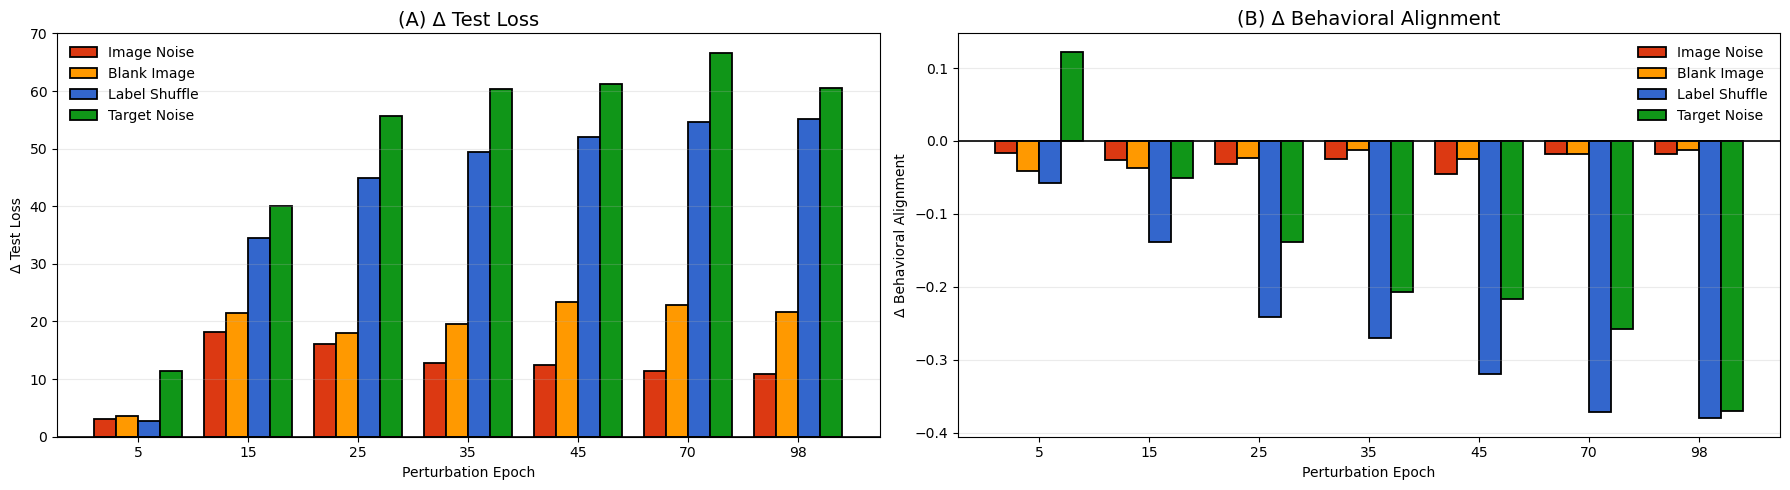

In [4]:
# Prepare data matrices for plotting
test_loss_matrix = np.array([in_dev, bi_dev, ls_dev, tn_dev])
behavior_matrix = np.array([in_ba, bi_ba, ls_ba, tn_ba])

perturb_names = ["Image Noise", "Blank Image", "Label Shuffle", "Target Noise"]
colors = ["#DC3912", "#FF9900", "#3366CC", "#109618"]

# Set up bar positions
x = np.arange(len(target_epochs))
bar_width = 0.2
offsets = [-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width]

# Create figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

# Panel A: Δ Test Loss
for i in range(4):
    ax1.bar(
        x + offsets[i],
        test_loss_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax1.axhline(0, color='black', linewidth=1.2)
ax1.set_xticks(x)
ax1.set_xticklabels(target_epochs)
ax1.set_title("(A) Δ Test Loss", fontsize=14)
ax1.set_xlabel("Perturbation Epoch")
ax1.set_ylabel("Δ Test Loss")
ax1.grid(axis="y", alpha=0.25)
ax1.legend(frameon=False)

# Panel B: Δ Behavioral Alignment
for i in range(4):
    ax2.bar(
        x + offsets[i],
        behavior_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax2.axhline(0, color='black', linewidth=1.2)
ax2.set_xticks(x)
ax2.set_xticklabels(target_epochs)
ax2.set_title("(B) Δ Behavioral Alignment", fontsize=14)
ax2.set_xlabel("Perturbation Epoch")
ax2.set_ylabel("Δ Behavioral Alignment")
ax2.grid(axis="y", alpha=0.25)
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()

## ViT Perturbation Experiments

### Load ViT Perturbation Results

In [5]:
import pandas as pd

# Load ViT perturbation effects data
df = pd.read_csv('../../Data/vit_results/perturbation_effects.csv')

print(f"Loaded {len(df)} measurements")
print(f"Perturbation types: {df['perturbation_type'].unique().tolist()}")
print(f"Epochs analyzed: {sorted(df['perturb_epoch'].unique().tolist())}")

df.head()

Loaded 44 measurements
Perturbation types: ['gaussian', 'uniform_gray', 'label_shuffle', 'target_noise']
Epochs analyzed: [5, 10, 15, 16, 20, 25, 30, 35, 45, 70, 98]


,perturb_epoch,perturbation_type,baseline_loss,baseline_rsa,perturbed_loss,perturbed_rsa,delta_loss,delta_rsa
0,5,gaussian,7.129578,0.411665,13.709656,0.041087,6.580078,-0.370578
1,5,uniform_gray,7.129578,0.411665,13.696409,0.024507,6.566831,-0.387157
2,5,label_shuffle,7.129578,0.411665,13.812166,0.066628,6.682588,-0.345037
3,5,target_noise,7.129578,0.411665,13.814077,0.070735,6.684499,-0.340929
4,10,gaussian,6.021348,0.441299,13.770599,0.037110,7.749251,-0.404189


### Create ViT Grouped Bar Plots

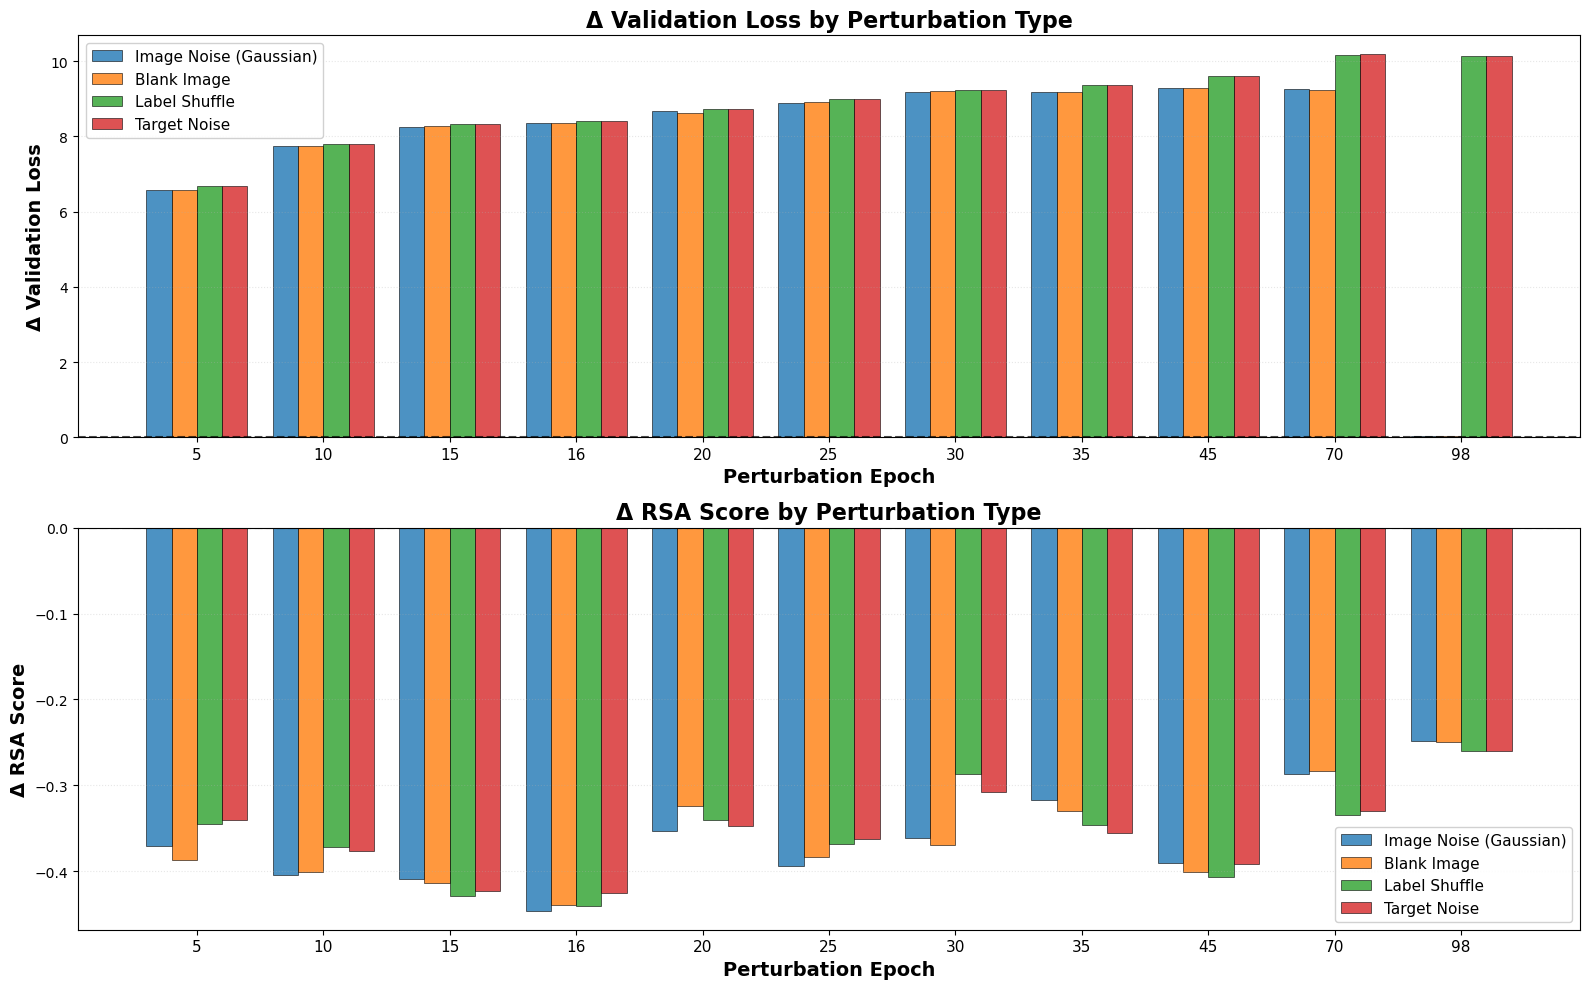

In [6]:
# Define perturbation type colors and labels
colors = {
    'gaussian': '#1f77b4',
    'uniform_gray': '#ff7f0e',
    'label_shuffle': '#2ca02c',
    'target_noise': '#d62728'
}

pretty_names = {
    'gaussian': 'Image Noise (Gaussian)',
    'uniform_gray': 'Blank Image',
    'label_shuffle': 'Label Shuffle',
    'target_noise': 'Target Noise'
}

# Get unique epochs and perturbation types
epochs = sorted(df['perturb_epoch'].unique())
perturb_types = df['perturbation_type'].unique()

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

metrics = [
    ('delta_loss', 'Δ Validation Loss', axes[0]),
    ('delta_rsa', 'Δ RSA Score', axes[1])
]

for metric_key, metric_label, ax in metrics:
    # Prepare data for grouped bar plot
    x_positions = np.arange(len(epochs))
    bar_width = 0.2
    num_types = len(perturb_types)
    
    for i, perturb_type in enumerate(perturb_types):
        # Get data for this perturbation type
        type_data = df[df['perturbation_type'] == perturb_type]
        
        # Align with available epochs
        values = []
        for epoch in epochs:
            epoch_data = type_data[type_data['perturb_epoch'] == epoch]
            if not epoch_data.empty:
                values.append(epoch_data[metric_key].values[0])
            else:
                values.append(np.nan)
        
        # Calculate offset for this perturbation type
        offset = (i - (num_types - 1) / 2) * bar_width
        
        # Plot bars
        ax.bar(x_positions + offset, values, bar_width,
               label=pretty_names.get(perturb_type, perturb_type),
               color=colors.get(perturb_type, 'gray'),
               alpha=0.8,
               edgecolor='black',
               linewidth=0.5)
    
    # Formatting
    ax.set_xlabel('Perturbation Epoch', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric_label, fontsize=14, fontweight='bold')
    ax.set_title(f'{metric_label} by Perturbation Type', fontsize=16, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(epochs, fontsize=11)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y', linestyle=':')

plt.tight_layout()
plt.show()